In [1]:
import os
import pandas as pd
import utils as utils

DATA_PATH = '../../backend/data/database/'

In [2]:
participants_df = pd.read_parquet(os.path.join(DATA_PATH, 'participants.parquet'))
participants_df.shape

(68, 8)

In [3]:
participants_df.sample(10)

,ParticipantId,TreatmentGroup,PoliticalLeaning,Tweet1,Tweet2,Tweet3,Tweet4,ParticipantStatus
18,601aa5ad4bb8ca3105c57b47,machine,8.0,R927,L463,R501,L988,finished
14,5f3692bf1640190638ebb687,placebo,2.0,R381,L181,R422,L262,finished
41,6478e0af8c176315633328e0,machine,5.0,R406,L812,L368,R405,finished
24,60bbe0da43325dadf2b1b6a9,placebo,3.0,L230,L744,R795,R618,finished
1,5ab848ffe1546900019b6ec9,machine,4.0,L211,L891,R942,R528,finished
51,664cc91532e124f91fce47e8,machine,3.0,R836,L884,R349,L957,finished
10,5e9f430a311b800cf2111800,human,NaN,R061,R188,L685,L128,started
44,651c0a8cc58ed94d241a03ba,placebo,3.0,L661,R112,R025,L202,finished
4,5c508d4ec150bc0001ff2de0,machine,NaN,R932,L636,R433,L746,started
55,66707803cfeaa5b818d5b136,placebo,6.0,R199,L649,L137,R077,finished


In [4]:
qualif_participants = participants_df.loc[participants_df['ParticipantStatus']=='finished'].reset_index(drop=True)
qualif_participants.shape

(63, 8)

In [5]:
qualif_participants['PoliticalLeaning'].value_counts()

PoliticalLeaning
3.0    22
2.0    15
5.0     9
4.0     6
8.0     5
6.0     3
1.0     2
7.0     1
Name: count, dtype: int64

<Axes: xlabel='PoliticalLeaning'>

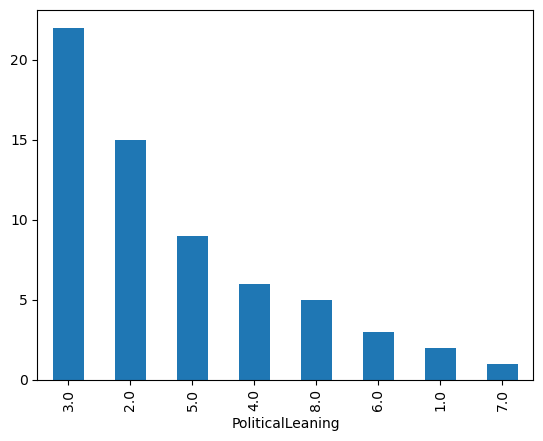

In [6]:
qualif_participants['PoliticalLeaning'].value_counts().plot.bar()

In [7]:
qualif_participants['TreatmentGroup'].value_counts()

TreatmentGroup
placebo    22
human      21
machine    20
Name: count, dtype: int64

<Axes: xlabel='TreatmentGroup'>

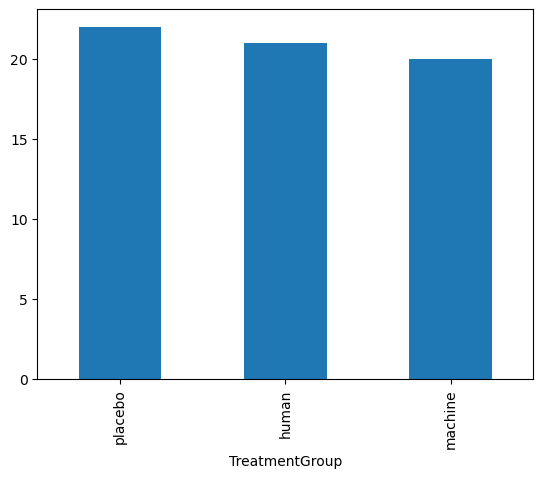

In [8]:
qualif_participants['TreatmentGroup'].value_counts().plot.bar()

In [9]:
answers_df = pd.read_parquet(os.path.join(DATA_PATH, 'answers.parquet'))
answers_df.shape

(253, 10)

In [10]:
answers_df.sample(10)

,AnswerId,FK_ParticipantId,FK_SessionId,Text1,Text2,AnswerQ1,AnswerQ2,AnswerQ3,AnswerQ4,TimeSpent
207,66707803cfeaa5b818d5b136T4,66707803cfeaa5b818d5b136,6711604cceb6e7ec4033d972,R077,PR077,4.0,4.0,4.0,1.0,39
164,65941845194f617bc81f2dacT1,65941845194f617bc81f2dac,6717753437e6a7a61bef6086,R509,PR509,5.0,5.0,5.0,3.0,40
110,6128088290e183700b1060e2T3,6128088290e183700b1060e2,67117a0257fc4774aa00ffcd,HR280,R280,4.0,5.0,4.0,2.0,35
139,62babccea6f10f16ce6a5a75T4,62babccea6f10f16ce6a5a75,67152bf8aaea0a4d2956c3be,L654,HL654,2.0,1.0,4.0,1.0,30
67,601deb10b1f15322f2887850T4,601deb10b1f15322f2887850,6718d49a5ffc8fe932a604f0,HR116,R116,3.0,5.0,2.0,2.0,80
35,5eaf1c50f3540c614eb973a5T4,5eaf1c50f3540c614eb973a5,6711614aad8445f3a8e8bbe5,L413,PL413,4.0,4.0,5.0,3.0,47
72,608b1ac239a12b93a41241bbT1,608b1ac239a12b93a41241bb,67121a5bb57f47dcac23bd95,L872,HL872,4.0,2.0,4.0,1.0,28
244,66ccf8abf9e250aa74ab1d3fT4,66ccf8abf9e250aa74ab1d3f,672ca6a6249de4f50ff42e37,HL054,L054,4.0,5.0,1.0,2.0,61
214,6679757dcf5a0a996e500673T3,6679757dcf5a0a996e500673,671157cb239fc9ef9e4b7f23,PR518,R518,5.0,5.0,5.0,3.0,29
233,66bab89594fb0f1b52769f64T1,66bab89594fb0f1b52769f64,6711ec89b7d9d677d9aee5ed,R107,PR107,5.0,5.0,5.0,3.0,119


In [11]:
qualif_answers = answers_df.loc[answers_df['FK_ParticipantId'].isin(qualif_participants['ParticipantId'].values)].reset_index(drop=True)
qualif_answers.shape

(252, 10)

In [12]:
qualif_answers.head(10)

,AnswerId,FK_ParticipantId,FK_SessionId,Text1,Text2,AnswerQ1,AnswerQ2,AnswerQ3,AnswerQ4,TimeSpent
0,57bb0ebfd4654c00018e0261T1,57bb0ebfd4654c00018e0261,671179cfd13e2cb0dc00fee4,MR749,R749,4.0,5.0,5.0,2.0,44
1,57bb0ebfd4654c00018e0261T2,57bb0ebfd4654c00018e0261,671179cfd13e2cb0dc00fee4,L167,ML167,3.0,3.0,5.0,3.0,43
2,57bb0ebfd4654c00018e0261T3,57bb0ebfd4654c00018e0261,671179cfd13e2cb0dc00fee4,MR050,R050,2.0,5.0,4.0,2.0,58
3,57bb0ebfd4654c00018e0261T4,57bb0ebfd4654c00018e0261,671179cfd13e2cb0dc00fee4,ML633,L633,4.0,4.0,5.0,2.0,64
4,5ab848ffe1546900019b6ec9T1,5ab848ffe1546900019b6ec9,671793db2e378b0de8b1321d,L211,ML211,5.0,2.0,4.0,1.0,59
5,5ab848ffe1546900019b6ec9T2,5ab848ffe1546900019b6ec9,671793db2e378b0de8b1321d,L891,ML891,5.0,2.0,4.0,1.0,55
6,5ab848ffe1546900019b6ec9T3,5ab848ffe1546900019b6ec9,671793db2e378b0de8b1321d,MR942,R942,4.0,5.0,2.0,2.0,66
7,5ab848ffe1546900019b6ec9T4,5ab848ffe1546900019b6ec9,671793db2e378b0de8b1321d,R528,MR528,4.0,2.0,4.0,1.0,40
8,5c131126d6d169000148414aT1,5c131126d6d169000148414a,67152faa5a48814cd9e7a281,PL159,L159,4.0,4.0,5.0,1.0,59
9,5c131126d6d169000148414aT2,5c131126d6d169000148414a,67152faa5a48814cd9e7a281,L482,PL482,4.0,4.0,4.0,3.0,21


In [13]:
new_values = []

for idx, row in qualif_answers.iterrows():
    treated_polar, treated_likert, original_polar, original_likert = utils.get_polar_info(row)
    treated_less_polar = utils.is_treated_less_polar(row)
    diff_likert_treated_original = utils.get_treat_diff(row)
    tweet_bias = utils.get_tt_bias(row['Text1'])
    participant_leaning = int(qualif_participants.loc[qualif_participants['ParticipantId']==row['FK_ParticipantId']]['PoliticalLeaning'].values[0])
    treatment_group = qualif_participants.loc[qualif_participants['ParticipantId']==row['FK_ParticipantId']]['TreatmentGroup'].values[0]
    new_values.append(
        {
            'TreatedIsPolarized' : treated_polar,
            'TreatedLikertValue' : treated_likert,
            'OriginalIsPolarized' : original_polar,
            'OriginalLikertValue' : original_likert,
            'TreatedIsLessPolar' : treated_less_polar,
            'DiffLikertTreatedOriginal' : diff_likert_treated_original,
            'TweetBias' : tweet_bias,
            'ParticipantLeaning' : participant_leaning,
            'TreatmentGroup' : treatment_group
        }
    )

In [14]:
new_columns = pd.DataFrame.from_records(new_values)
new_columns.sample(5)

,TreatedIsPolarized,TreatedLikertValue,OriginalIsPolarized,OriginalLikertValue,TreatedIsLessPolar,DiffLikertTreatedOriginal,TweetBias,ParticipantLeaning,TreatmentGroup
89,0,1,0,2,1,-3,L,5,human
24,0,2,1,4,1,-3,L,4,placebo
51,1,4,1,5,1,-1,R,3,machine
91,-1,3,1,4,1,-1,L,5,human
182,1,4,1,4,0,-1,L,4,machine


In [15]:
answers_data = pd.concat([qualif_answers, new_columns], axis=1)
answers_data.sample(10)

,AnswerId,FK_ParticipantId,FK_SessionId,Text1,Text2,AnswerQ1,AnswerQ2,AnswerQ3,AnswerQ4,TimeSpent,TreatedIsPolarized,TreatedLikertValue,OriginalIsPolarized,OriginalLikertValue,TreatedIsLessPolar,DiffLikertTreatedOriginal,TweetBias,ParticipantLeaning,TreatmentGroup
164,65941845194f617bc81f2dacT1,65941845194f617bc81f2dac,6717753437e6a7a61bef6086,R509,PR509,5.0,5.0,5.0,3.0,40,1,5,1,5,0,0,R,2,placebo
62,601aa5ad4bb8ca3105c57b47T3,601aa5ad4bb8ca3105c57b47,671178ab14f64e5eec7d6b3d,R501,MR501,4.0,2.0,4.0,1.0,20,0,2,1,4,1,-2,R,8,machine
34,5eaf1c50f3540c614eb973a5T3,5eaf1c50f3540c614eb973a5,6711614aad8445f3a8e8bbe5,PL777,L777,3.0,3.0,5.0,3.0,33,-1,3,-1,3,0,0,L,2,placebo
185,6648a891957434ad183ce6b4T2,6648a891957434ad183ce6b4,671219dabe180964f75b344b,PL601,L601,3.0,3.0,5.0,3.0,69,-1,3,-1,3,0,0,L,2,placebo
245,66d6c656018a013f3c049a3cT2,66d6c656018a013f3c049a3c,6712566a9b47f51f3dfec246,ML920,L920,1.0,3.0,5.0,2.0,73,0,1,-1,3,1,-2,L,3,machine
174,66072bcf065f7722b6e6ec0cT3,66072bcf065f7722b6e6ec0c,671157e5bfc7c4e1195362e7,R186,HR186,5.0,4.0,5.0,1.0,52,1,4,1,5,1,-1,R,3,human
200,666aee5dc01e66ffad32389eT1,666aee5dc01e66ffad32389e,67165373b7dc60847e0cf945,L278,ML278,3.0,3.0,3.0,1.0,54,-1,3,-1,3,1,0,L,3,machine
5,5ab848ffe1546900019b6ec9T2,5ab848ffe1546900019b6ec9,671793db2e378b0de8b1321d,L891,ML891,5.0,2.0,4.0,1.0,55,0,2,1,5,1,-2,L,4,machine
119,614e000eeaf975d22cba5445T4,614e000eeaf975d22cba5445,67118865727d56035ea3657b,ML881,L881,4.0,5.0,5.0,2.0,160,1,4,1,5,1,-1,L,3,machine
58,60185c812e31c90cbd82f28cT3,60185c812e31c90cbd82f28c,67124dac9e2123793aee0047,PL430,L430,4.0,5.0,4.0,2.0,26,1,4,1,5,1,-1,L,3,placebo
